<a href="https://colab.research.google.com/github/plue1011/PyTorch/blob/master/practice/CIFAR10_captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://captum.ai/tutorials/CIFAR_TorchVision_Interpret

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
!pip install captum

     |████████████████████████████████| 1.4MB 9.5MB/s 


# シンプルなCNN

In [0]:
import cv2
import os
import copy
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score

from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

## データ準備

In [3]:
# データの読み込み
root_path = '/content/drive/My Drive/study/CNN/dataset/CIFAR10'
train_set = torchvision.datasets.CIFAR10(root=root_path, train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root=root_path, train=False, download=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# 飛行機と車だけ抽出
train_set_class01 = []
train_labels = []
for data, label in train_set:
    if label == 0 or label == 1:
        train_set_class01.append(data)
        train_labels.append(label)

test_set_class01 = []
test_labels = []
for data, label in test_set:
    if label == 0 or label == 1:
        test_set_class01.append(data)
        test_labels.append(label)

In [0]:
#  transformの作成
transform = transforms.Compose(
    [transforms.ToTensor(),  # tensor型に変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 画像を正規化
    ])

In [0]:
# Datasetの作成
class MyDataset(Dataset):
    def __init__(self, dataset, labels, transform=None):
        self.transform = transform
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    # データをtransformで前処理してから返している
    def __getitem__(self, idx):
        out_data = self.dataset[idx]
        out_label =  self.labels[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label
    
train_dataset = MyDataset(train_set_class01, train_labels, transform)
test_dataset = MyDataset(test_set_class01, test_labels, transform)

In [0]:
# DataLoaderの作成
## 訓練データをさらに「訓練データ」と「検証データ」に分ける(検証データ!=テストデータ)
n_samples = len(train_dataset)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val])

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

## モデルの構築

In [0]:
# モデルの構築
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
# モデルの構築
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
model = CNN().to(device)

In [10]:
weights = torch.load("/content/drive/My Drive/study/CNN/weights/simple_model.pth", map_location={"cuda:0": "cpu"})
model.load_state_dict(weights)

<All keys matched successfully>

## captum

In [0]:
# captumを使用する上での汎用関数
def attribute_image_features(algorithm, input_data, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input_data,
                                              target=label,
                                              **kwargs
                                             )
    
    return tensor_attributions

予測

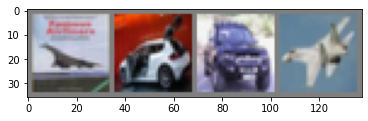

GroundTruth:  plane   car   car plane
Predicted:  plane   car   car plane


In [20]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(test_dataloader)
images, labels = data_iter.next()
images, labels = images[:4].to(device), labels[:4].to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

### 3番目のデータを使うことにする

In [0]:
ind = 3

input_img = images[ind].unsqueeze(0)
label = labels[ind]
input_img.requires_grad = True

In [27]:
# 推論モードに変更
model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [33]:
ggc = GuidedGradCam(model.to(device), model.eval().conv1)
attr_ggc = attribute_image_features(ggc, input_img, label)
attr_ggc = np.transpose(attr_ggc.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


Original Image
Predicted: plane  Probability: 0.9999939203262329


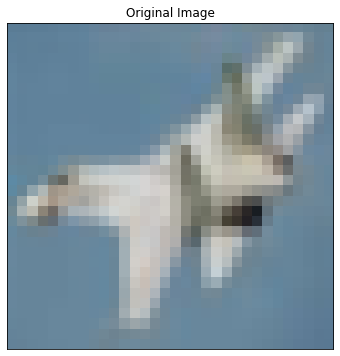

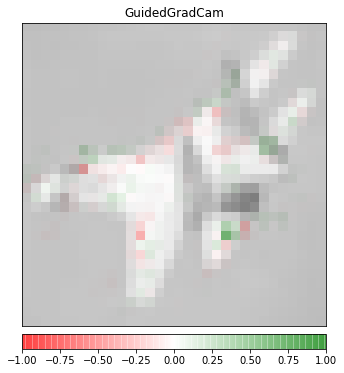

In [34]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")
_ = viz.visualize_image_attr(attr_ggc, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="GuidedGradCam")

### 2番目のデータを使うことにする

In [0]:
ind = 2

input_img = images[ind].unsqueeze(0)
label = labels[ind]
input_img.requires_grad = True

In [39]:
# 推論モードに変更
model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [47]:
ggc = GuidedGradCam(model.to(device), model.eval().conv1)
attr_ggc = attribute_image_features(ggc, input_img, label)
attr_ggc = np.transpose(attr_ggc.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


Original Image
Predicted: car  Probability: 0.9999939203262329


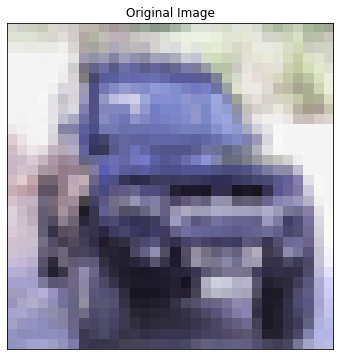

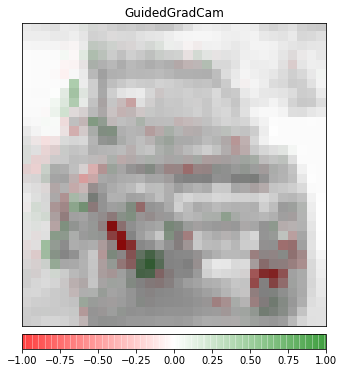

In [48]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")
_ = viz.visualize_image_attr(attr_ggc, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="GuidedGradCam")